In [1]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

from utils.params import Params
from utils.agent import QLearningAgent
from utils.post_process import post_process
from utils.visualization import plot_rewards_and_steps

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from pathlib import Path

sns.set_theme()

## Parameters

In [128]:
total_episodes = 2_000
initial_epsilon = 0.1

params = Params(
    total_episodes=total_episodes,
    learning_rate=0.8,
    discount_factor=0.95,
    initial_epsilon=initial_epsilon,
    epsilon_decay=initial_epsilon / (total_episodes / 2), # reduce the exploration over time
    final_epsilon=0.1,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("fig/frozenlake-v1/"),
    seed=123
)

# create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

## Training loop

In [129]:
def train(env: gym.Env, agent: QLearningAgent):
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # run several times to account for stochasticity
        agent.reset_qtable()  # reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            # play episode
            while not done:
                action = agent.get_action(
                     state=state, 
                     action_space=env.action_space
                )

                # log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                # update the agent
                agent.update(
                    state=state, 
                    action=action, 
                    reward=reward,
                    terminated=terminated, 
                    new_state=new_state
                )

                total_rewards += reward
                step += 1

                # new state is now state
                state = new_state

            # log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = agent.qtable
        agent.decay_epsilon()

    return rewards, steps, episodes, qtables, all_states, all_actions

## Training the agent

Running the agent on a few increasing maps sizes: 4x4

In [130]:
map_sizes = [4, 7, 9, 11]
training_steps_df = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # set the seed to get reproducible results when sampling the action space
    
    agent = QLearningAgent(
        learning_rate=params.learning_rate,
        discount_factor=params.discount_factor,
        state_size=params.state_size,
        action_size=params.action_size,
        initial_epsilon=params.initial_epsilon, 
        epsilon_decay=params.epsilon_decay, 
        final_epsilon=params.final_epsilon, 
        rng_seed=params.seed
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = train(env, agent)

    # process results and add to dataframe
    results, _steps = post_process(episodes, params, rewards, steps, map_size)
    training_results_df = pd.concat([training_results_df, results])
    training_steps_df = pd.concat([training_steps_df, _steps])

    env.close()

Map size: 4x4


Map size: 7x7


Map size: 9x9


Map size: 11x11


## Results

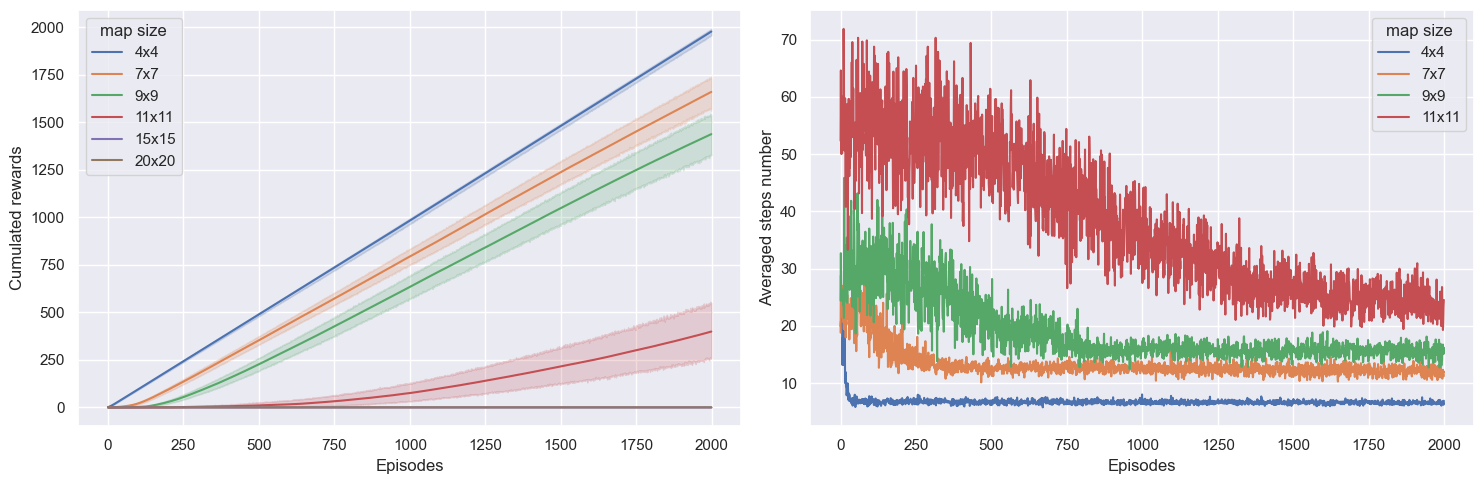

In [132]:
# plot cumulated sum of rewards and number of steps needed until end of episode
# cumulated sum of rewards is expected to increase if agent is learning
# number of steps is expected to decrease if agent is learning
plot_rewards_and_steps(training_results_df, training_steps_df, params.savefig_folder, True)
